# compare beams from different observations

In [1]:
import os
from astropy.io import fits
import pandas as pd
from astropy import modeling
import numpy as np
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.interpolate import RectBivariateSpline
from reproject import reproject_interp

mpl.rcParams['font.family'] = 'serif'
%matplotlib inline


# Using regridded beam models

In [ ]:
date = '190912'
date2 = '200430'
nrows = 7
ncols = 7*2+1
beams = 40


fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, figure=fig) #, width_ratios=[1]*ncols, height_ratios=[1]*nrows, wspace=0.4, hspace=0.7)

# Arrange the plots approx according to beam spacing (only beam 0 really fails)
ax = [None] * beams
for b in range(beams-1,-1,-1):
    if (b <= 39) & (b >= 33):
        ax[b] = fig.add_subplot(gs[0,2*(39-b):2*(39-b)+2])
    if (b <= 32) & (b >= 27):
        ax[b] = fig.add_subplot(gs[1,2*(32-b)+1:2*(32-b)+2+1])
    if (b <= 26) & (b >= 21):
        ax[b] = fig.add_subplot(gs[2,2*(26-b)+2:2*(26-b)+2+2])
    if (b == 0):
        ax[b] = fig.add_subplot(gs[3,2*3:2*3+2])
    if (b <= 20) & (b >= 15):
        ax[b] = fig.add_subplot(gs[4,2*(20-b)+1:2*(20-b)+2+1])
    if (b <= 14) & (b >= 8):
        ax[b] = fig.add_subplot(gs[5,2*(14-b):2*(14-b)+2])
    if (b <= 7) & (b >= 1):
        ax[b] = fig.add_subplot(gs[6,2*(7-b)+1:2*(7-b)+2+1])
    ax[b].set_xticks([])
    ax[b].set_yticks([])

    
for b in range(beams):
    hdu = fits.open('/tank/denes/drift_scan/{}/cont/{}_{:02}_I_model_reg.fits'.format(date, date, b))
    hdu2 = fits.open('/tank/denes/drift_scan/{}/cont/{}_{:02}_I_model_reg.fits'.format(date2, date2, b))

    data = hdu[0].data
    data2 = hdu2[0].data
    dif = data2[1000:2100,1000:2100] / data[1000:2100,1000:2100]
    cb = ax[b].imshow(dif, vmin=0.5, vmax=1.5, cmap='RdBu')
    ax[b].set_title('Beam '+str(b).zfill(2))
    ax[b].contour(dif, levels=[0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4], colors='black')
    ax[b].invert_yaxis()

fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.15, 0.015, 0.7])
cbar =fig.colorbar(cb, cax=cbar_ax)
cbar.minorticks_on()
cbar.ax.tick_params(labelsize=18) 
#cbar.ax.set_ylabel('e$_{FWHM}$ [km s$^{-1}$]', fontsize=20)

plt.savefig('/tank/denes/drift_scan/dif_plots/{}_dif_{}.png'.format(date, date2), bbox_inches="tight", dpi=200)


# Using new beam models
40 x 40 pixel fits images

In [4]:
def compare_beams(date, date2):
    #date = '201009'
    #date2 = '200430'
    nrows = 7
    ncols = 7*2+1
    beams = 40
    dif_1 = []


    fig = plt.figure(figsize=(12,12))
    gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, figure=fig) #, width_ratios=[1]*ncols, height_ratios=[1]*nrows, wspace=0.4, hspace=0.7)

    #plt.title('{}/{}'.format(date2, date))
    plt.axis("off")

    # Arrange the plots approx according to beam spacing (only beam 0 really fails)
    ax = [None] * beams
    for b in range(beams-1,-1,-1):
        if (b <= 39) & (b >= 33):
            ax[b] = fig.add_subplot(gs[0,2*(39-b):2*(39-b)+2])
        if (b <= 32) & (b >= 27):
            ax[b] = fig.add_subplot(gs[1,2*(32-b)+1:2*(32-b)+2+1])
        if (b <= 26) & (b >= 21):
            ax[b] = fig.add_subplot(gs[2,2*(26-b)+2:2*(26-b)+2+2])
        if (b == 0):
            ax[b] = fig.add_subplot(gs[3,2*3:2*3+2])
        if (b <= 20) & (b >= 15):
            ax[b] = fig.add_subplot(gs[4,2*(20-b)+1:2*(20-b)+2+1])
        if (b <= 14) & (b >= 8):
            ax[b] = fig.add_subplot(gs[5,2*(14-b):2*(14-b)+2])
        if (b <= 7) & (b >= 1):
            ax[b] = fig.add_subplot(gs[6,2*(7-b)+1:2*(7-b)+2+1])
        ax[b].set_xticks([])
        ax[b].set_yticks([])


    for b in range(beams):
        hdu = fits.open('/tank/apertif/driftscans/fits_files/{}/beam_models/chann_5/{}_{:02}_I_model.fits'.format(date, date, b))
        hdu2 = fits.open('/tank/apertif/driftscans/fits_files/{}/beam_models/chann_5/{}_{:02}_I_model.fits'.format(date2, date2, b))

        data = hdu[0].data
        data2 = hdu2[0].data
        #print(data.shape, data2.shape)
        dif = data2 / data
        #print(np.median(dif))
        dif_1.append(np.abs(1-np.median(dif))*100)
        cb = ax[b].imshow(dif, vmin=0.5, vmax=1.5, cmap='RdBu')
        ax[b].set_title('Beam '+str(b).zfill(2))
        ax[b].contour(dif, levels=[0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4], colors='black')
        ax[b].invert_yaxis()

    fig.subplots_adjust(right=0.94)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.015, 0.7])
    cbar =fig.colorbar(cb, cax=cbar_ax)
    cbar.minorticks_on()
    cbar.ax.tick_params(labelsize=18) 
    #cbar.ax.set_ylabel('e$_{FWHM}$ [km s$^{-1}$]', fontsize=20)
    dif_1=np.array(dif_1)
    print(np.mean(dif_1), dif_1)

    plt.savefig('/tank/denes/drift_scan/dif_plots/{}_dif_{}.png'.format(date, date2), bbox_inches="tight", dpi=200)


1.4981829078574038 [0.39486446 0.06991318 0.2573688  0.73775556 0.78379015 1.84777175
 1.22375948 1.81240929 5.24188721 5.81558278 3.30994017 0.08605421
 1.5994225  0.12181498 2.31169833 2.59827455 0.60303924 1.32555297
 4.39192906 1.19822151 0.74750712 3.75467754 3.57778965 0.85524246
 1.23032778 4.57970245 5.87130233 0.01910841 0.466246   0.11869518
 0.19316021 0.17397131 0.62628015 0.78072582 0.1005922  0.12736332
 0.35131087 0.46647095 0.14424197 0.0115504 ]
1.4675225944694252 [0.79861396 0.06979438 0.25736825 0.73775221 0.78437002 1.8477784
 1.22498883 1.81240888 5.12611054 5.98554972 3.25851505 0.12183482
 1.58685968 0.10908235 2.29678407 2.97767436 0.63524685 0.27767667
 4.26871986 1.11401346 0.47381942 4.01692154 3.41543861 1.83036955
 1.89466507 4.78493109 5.76152347 0.17866544 0.01654362 0.17591293
 0.41336821 0.13416456 0.07538389 0.05613419 0.02102433 0.02166503
 0.00605777 0.0076138  0.08145384 0.04410508]
1.2752620812679674 [1.62858886 0.30319434 0.85296543 0.9425294  0.9

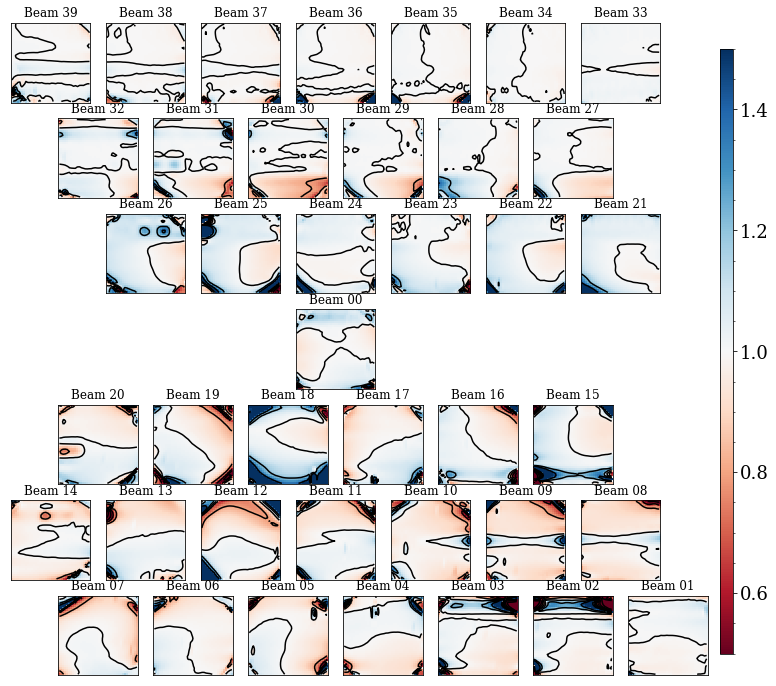

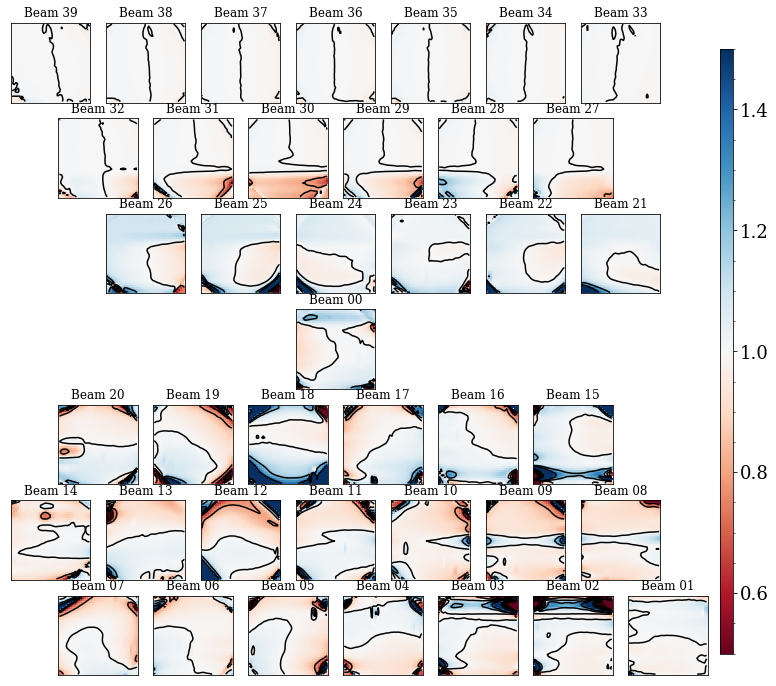

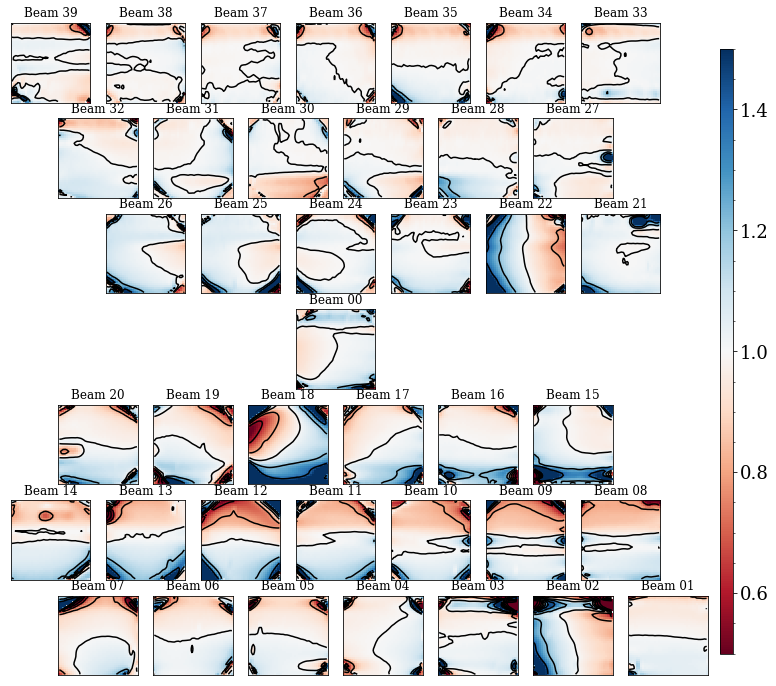

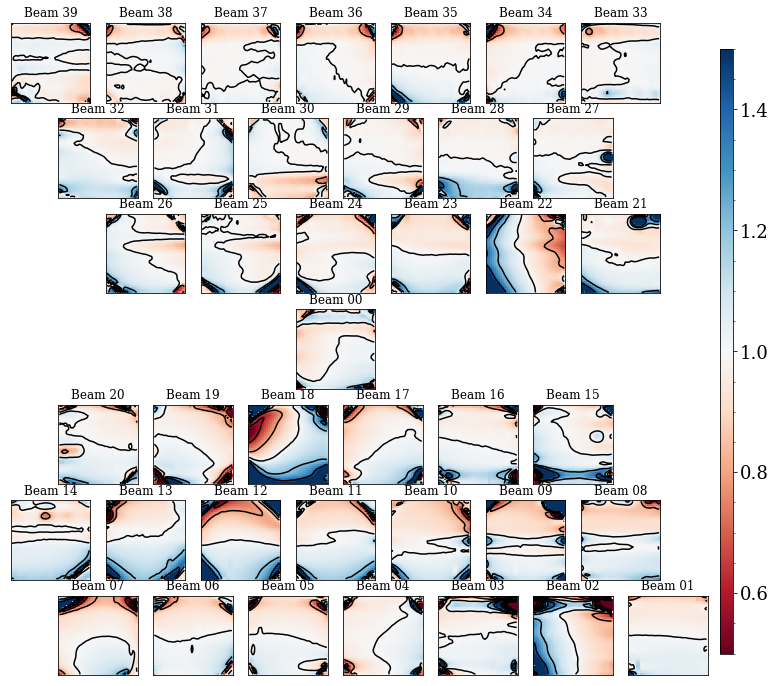

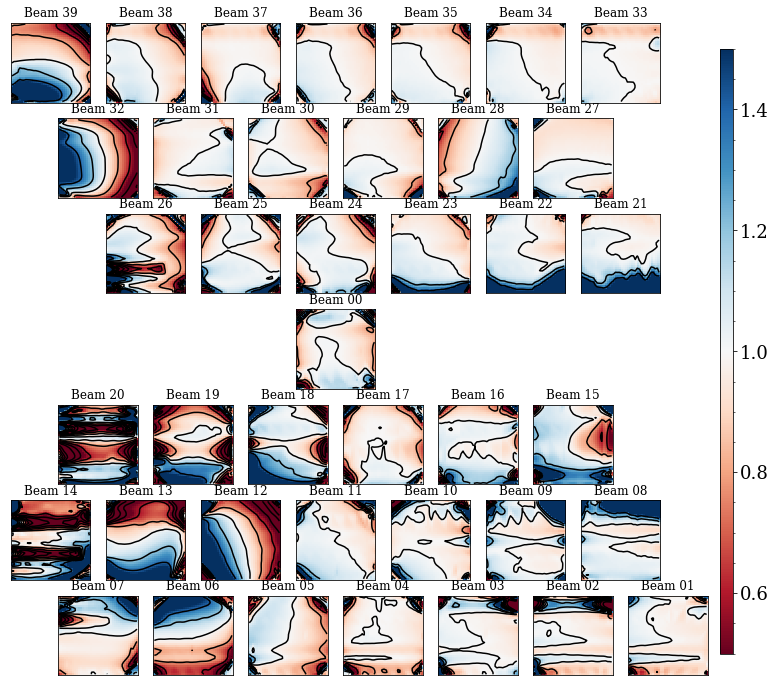

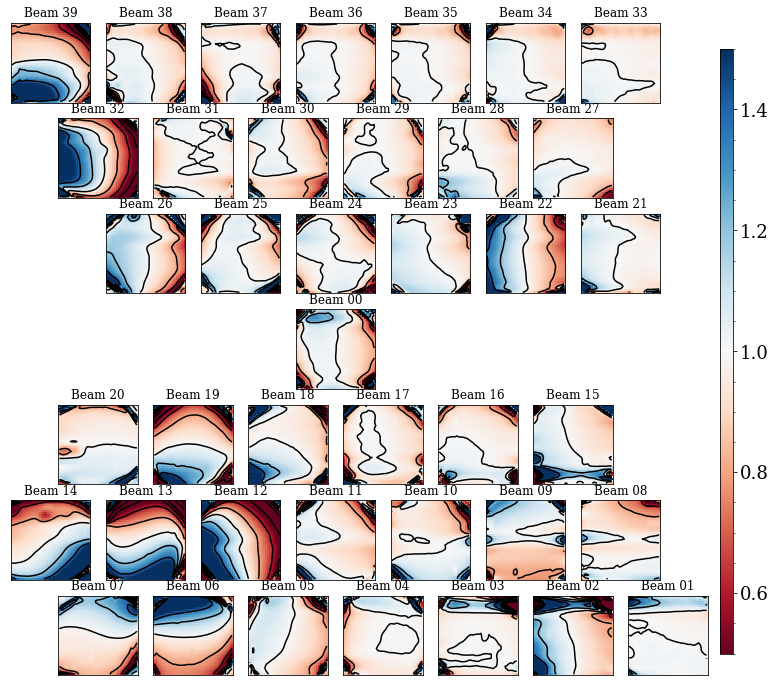

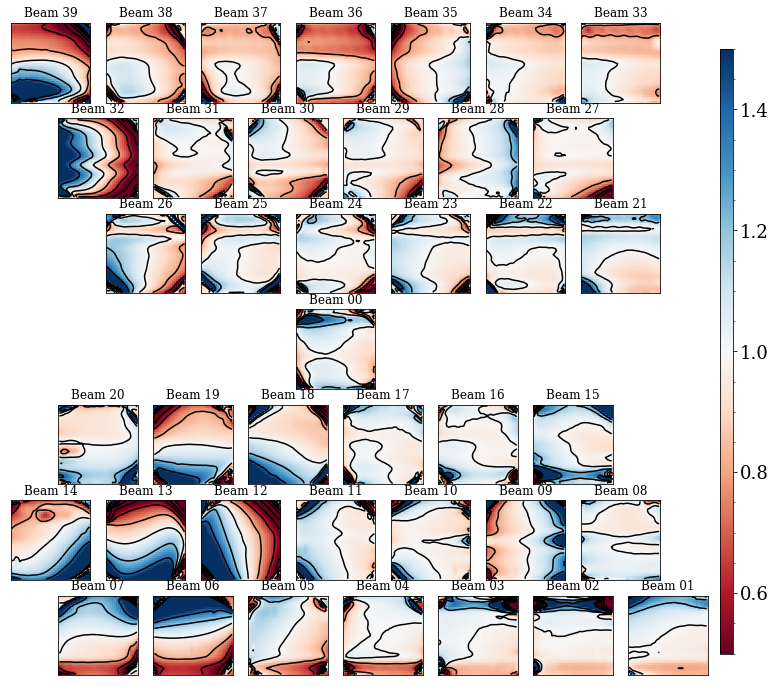

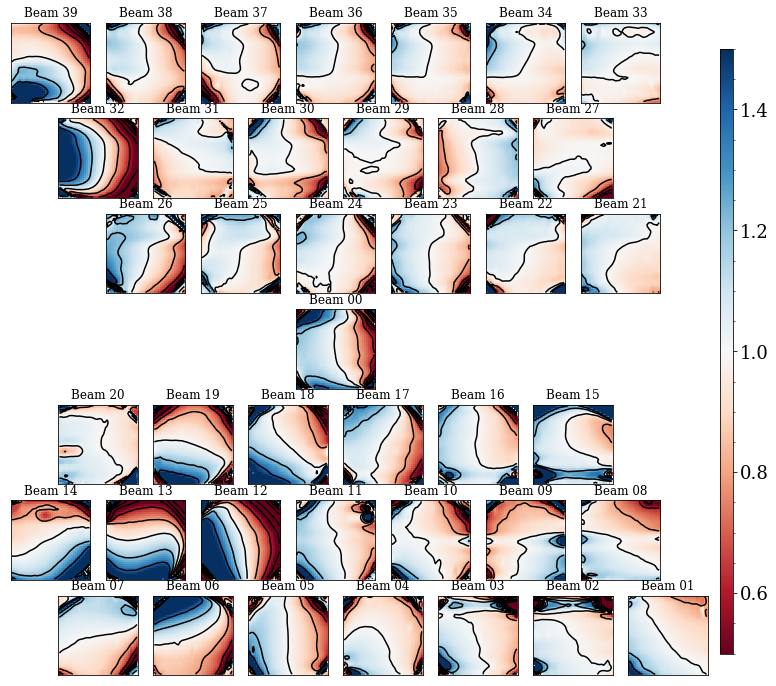

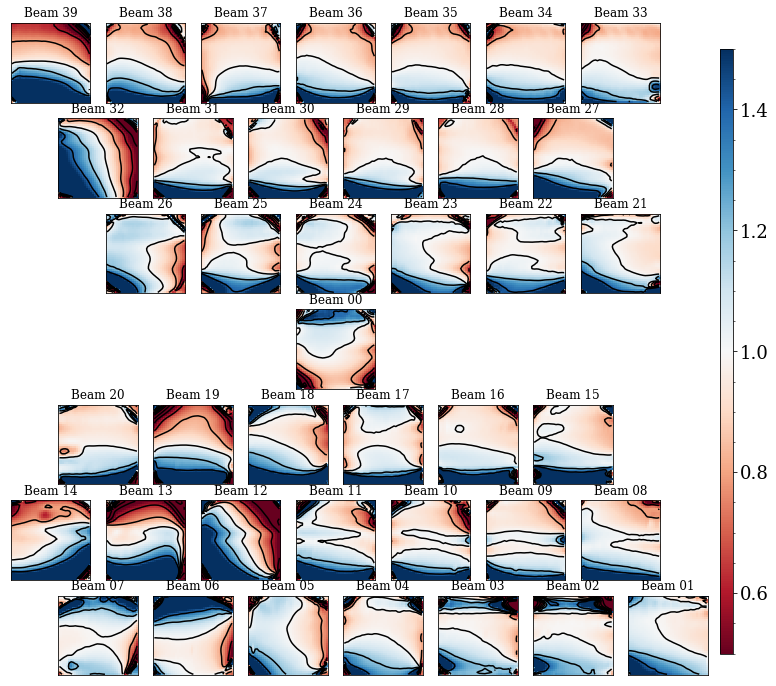

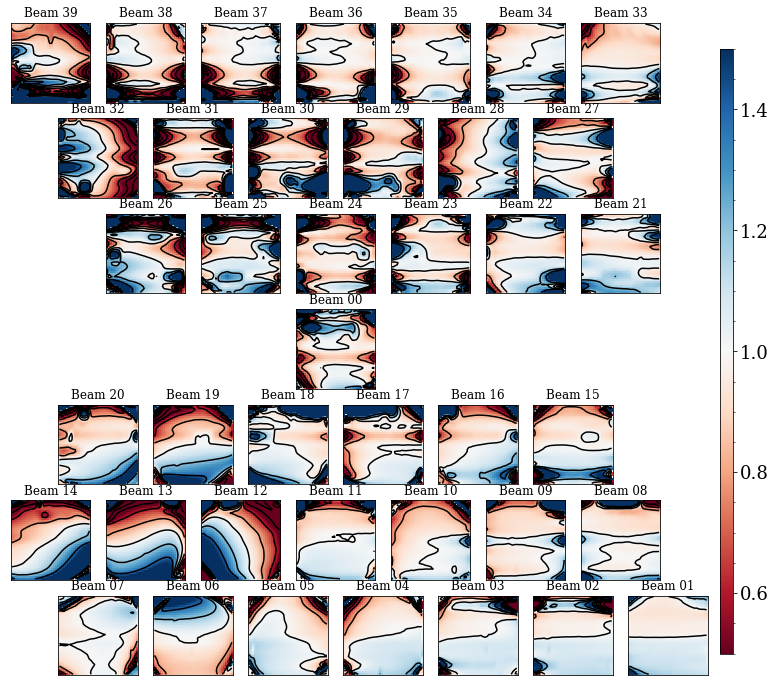

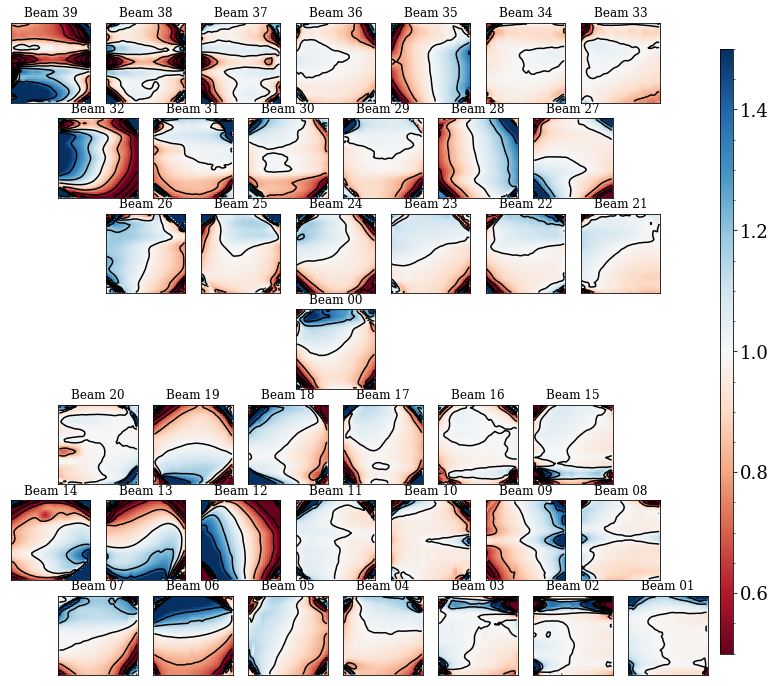

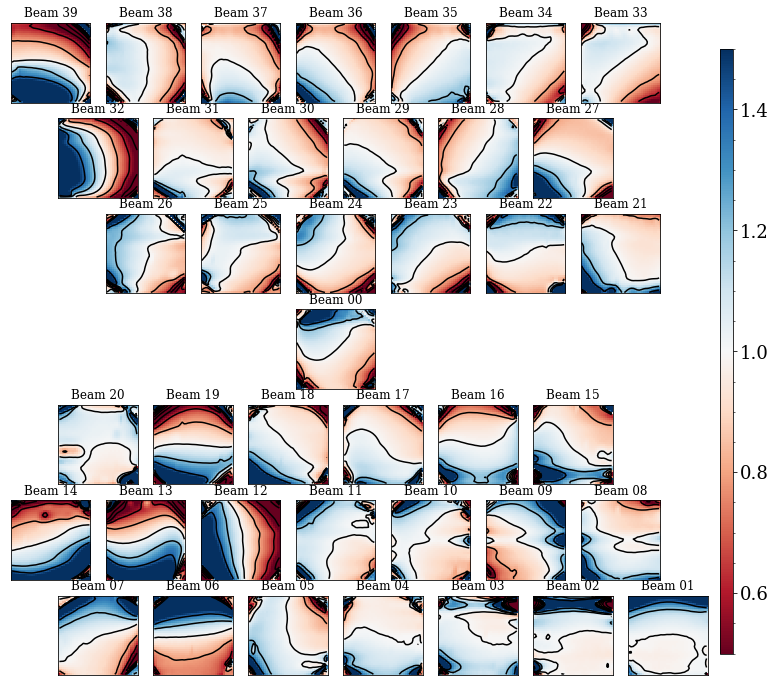

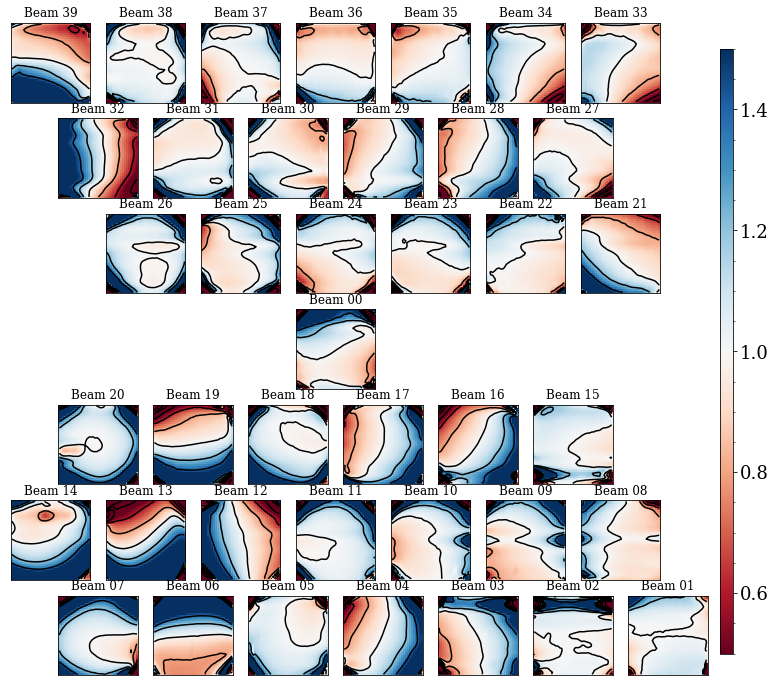

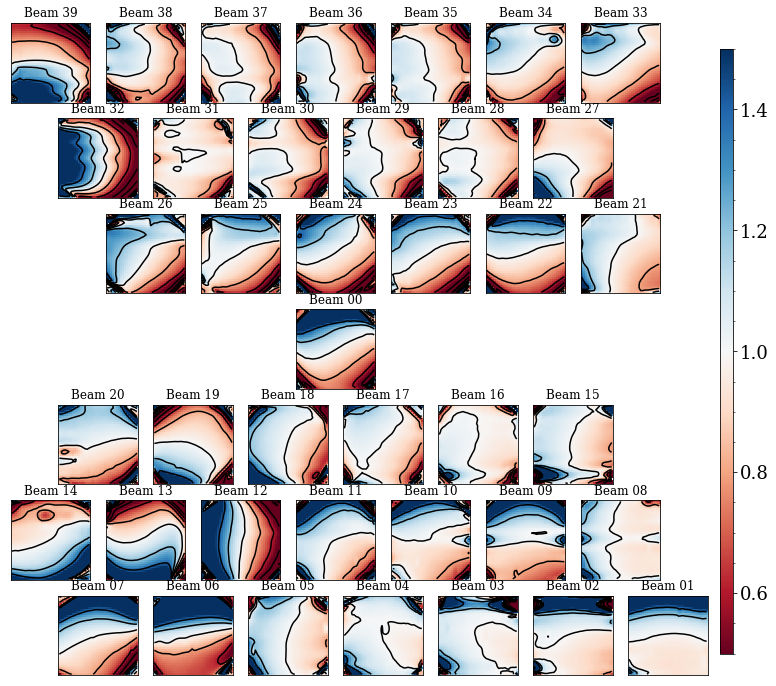

In [5]:
dates = ['190821', '190826', '190912', '190916', '191008', '191023', '191120', '200130', '200430', '200710', '200819', '201009', '201028', '201218']

for i in dates:
    compare_beams('190722', i)